In [ ]:
# region import
import numpy as np
import pandas as pd
from backtesting import Strategy, Backtest
import joblib
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Backtest
# endregion

In [ ]:
class ElderImpulseADX(Strategy):
    multi = 4
    threshold = -4
    entry_pct = 1

    def init(self):
        close = pd.Series(self.data.Close)
        high = pd.Series(self.data.High)
        low = pd.Series(self.data.Low)
        src = talib.WMA(close, timeperiod=20)
        
        # === VOLA ===
        rets = close.pct_change()
        f_volatility = rets.ewm(self.multi * 30).std()
        s_volatility = rets.rolling(window=self.multi * 365).std()
        vola_ratio = f_volatility / s_volatility

        # === MACD ===
        ema_fast = src.ewm(span=12 * self.multi, adjust=False).mean()
        ema_slow = src.ewm(span=26 * self.multi, adjust=False).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=9 * self.multi, adjust=False).mean()
        macd_hist = (macd - macd_signal).shift(1)

        # === EMA Trend ===
        ema_val = src.ewm(span=21 * self.multi, adjust=False).mean().shift(1)

        # === Directional Movement (+DI, -DI, ADX) ===
        up = high.diff()
        down = -low.diff()
        plusDM = np.where((up > down) & (up > 0), up, 0.0)
        minusDM = np.where((down > up) & (down > 0), down, 0.0)

        tr = np.maximum.reduce([
            (high - low).to_numpy(),
            (high - close.shift()).abs().to_numpy(),
            (low - close.shift()).abs().to_numpy()
        ])

        atr = pd.Series(tr).rolling(14 * self.multi, min_periods=1).mean()

        plusDI = (100 * pd.Series(plusDM).rolling(14 * self.multi, min_periods=1).mean() / atr).shift(1)
        minusDI = (100 * pd.Series(minusDM).rolling(14 * self.multi, min_periods=1).mean() / atr).shift(1)

        dx = (100 * (plusDI - minusDI).abs() / (plusDI + minusDI)).fillna(0)
        adx = dx.rolling(14 * self.multi, min_periods=1).mean().shift(1)

        # === Store indicators ===
        atr = talib.ATR(high.to_numpy(), low.to_numpy(), close.to_numpy(), timeperiod=14*self.multi)
        self.kelly = self.I(lambda: vola_ratio.to_numpy())
        self.macd_hist = self.I(lambda: macd_hist.to_numpy(), plot = False) / atr
        self.ema_val = self.I(lambda: ema_val.to_numpy())
        self.plusDI = self.I(lambda: plusDI.to_numpy(), plot=False)
        self.minusDI = self.I(lambda: minusDI.to_numpy(), plot=False)
        self.adx = self.I(lambda: adx.to_numpy(), plot=False)
        
    def next(self):
        bull = (self.ema_val[-1] > self.ema_val[-2]) and \
               (self.macd_hist[-1] > self.macd_hist[-2]) and \
               (self.plusDI[-1] > self.minusDI[-1] + self.threshold) and \
               (self.adx[-1] >= 6)

        bear = (self.ema_val[-1] < self.ema_val[-2]) and \
               (self.macd_hist[-1] < self.macd_hist[-2]) and \
               (self.minusDI[-1] > self.plusDI[-1] + self.threshold)
        
        kelly = self.kelly[-1]
        kelly = min(max(kelly, 0.1), 1)
        
        if bull:
            if not self.position:
                self.buy(size = self._FULL_EQUITY * kelly * self.entry_pct)
                    
        elif bear:
            if self.position.is_long:
                self.position.close()

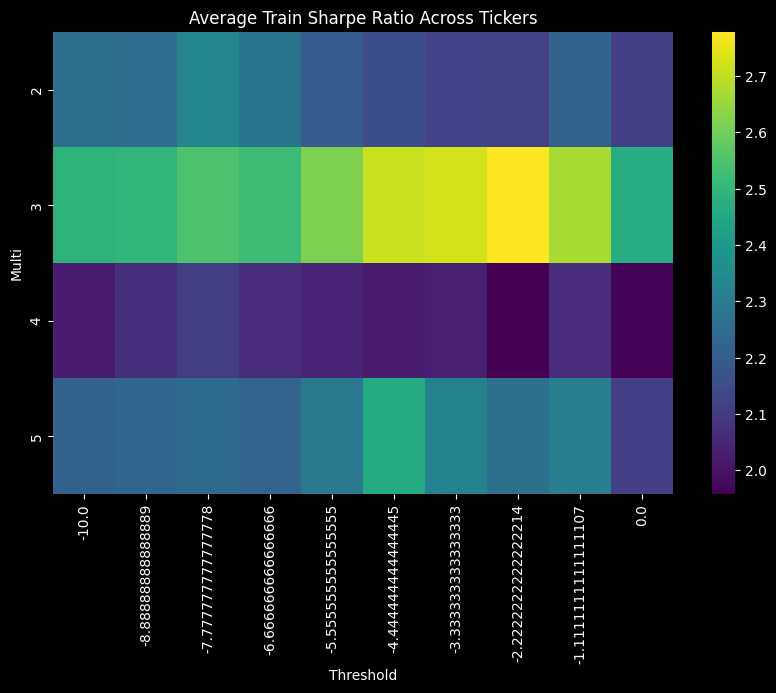


Averaged params → Multi: 3, Threshold: -3.333


In [ ]:
datas = joblib.load('/Users/leoinv/Documents/CODE/BACKTEST/data/1h.joblib')

train_ratio = 0.7
multi = np.linspace(2, 5, 10, dtype=int)
thresholds = np.linspace(-10, 0, 10)

# Step 1: Sweep Sharpe across all tickers' train sets
sweep_results = []
i = 0
for ticker, data in datas.items():
    i += 1
    if i > 5:
        break
    if ticker == 'XLMUSDT':
        continue
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data.set_index('Date', inplace=True)
    data = data.dropna()

    if len(data) <= 30000:
        continue

    # Split train/test
    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]

    for m in multi:
        for th in thresholds:
            bt_train = Backtest(train_data, ElderImpulseADX,
                                cash=1000000000, commission=.0005)
            stats = bt_train.run(multi=m, threshold=th)
            sweep_results.append((m, th, stats['Sortino Ratio'], ticker))

# Step 2: Average Sharpe for each param pair
df_sweep = pd.DataFrame(sweep_results, columns=['Multi', 'Threshold', 'Sharpe', 'Ticker'])
avg_sweep = df_sweep.groupby(['Multi', 'Threshold'])['Sharpe'].mean().reset_index()

# Step 3: Create heatmap
pivot = avg_sweep.pivot(index='Multi', columns='Threshold', values='Sharpe')

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=False)
plt.title("Average Train Sharpe Ratio Across Tickers")
plt.show()

# Get top 3 rows by Sharpe
top5 = avg_sweep.nlargest(5, 'Sharpe')

# Average their parameters
best_multi = int(round(top5['Multi'].mean()))
best_threshold = top5['Threshold'].mean()

print(f"\nAveraged params → Multi: {best_multi}, Threshold: {best_threshold:.3f}")

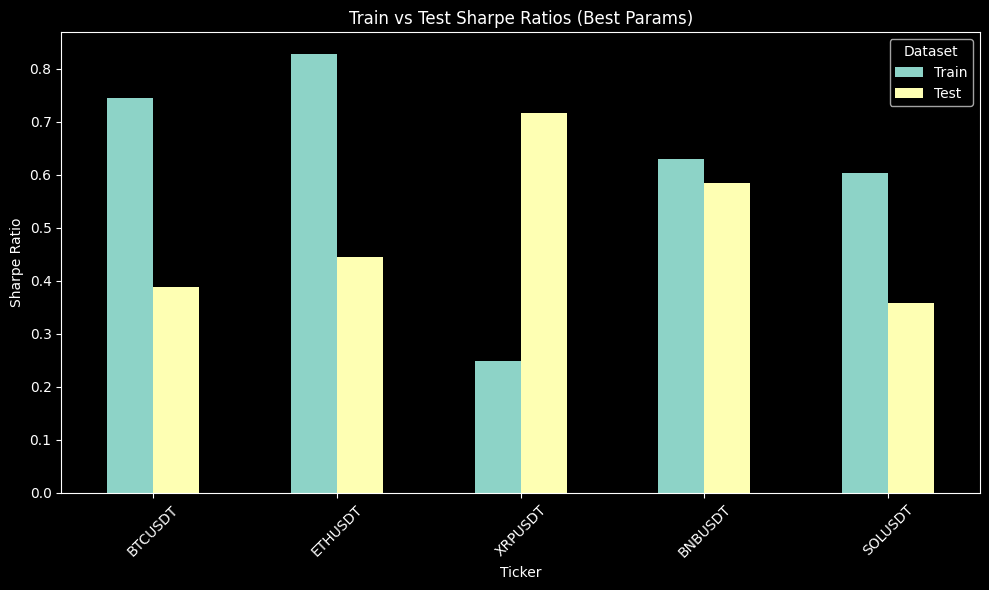

In [ ]:
# Step 5: Run test set with best params
train_results = {}
test_results = {}

train_equities = {}
test_equities = {}

i = 0
for ticker, data in datas.items():
    if ticker == 'XLMUSDT':
        continue
    i += 1
    if i > 5:
        break
    data = data.dropna()

    if len(data) <= 30000:
        continue

    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    # Train run
    bt_train = Backtest(train_data, ElderImpulseADX, cash=1000000000, commission=.0005)
    stats_train = bt_train.run(multi=best_multi, threshold=best_threshold)
    train_results[ticker] = stats_train['Sharpe Ratio']
    train_equities[ticker] = stats_train['_equity_curve']['Equity'].pct_change().cumsum() + 1

    # Test run
    bt_test = Backtest(test_data, ElderImpulseADX, cash=1000000000, commission=.0005)
    stats_test = bt_test.run(multi=best_multi, threshold=best_threshold)
    test_results[ticker] = stats_test['Sharpe Ratio']
    test_equities[ticker] = stats_test['_equity_curve']['Equity'].pct_change().cumsum() + 1

# Step 6: Compare Train vs Test Sharpe
df_results = pd.DataFrame({
    "Train": pd.Series(train_results),
    "Test": pd.Series(test_results)
}).dropna(how="all")

df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Train vs Test Sharpe Ratios (Best Params)")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

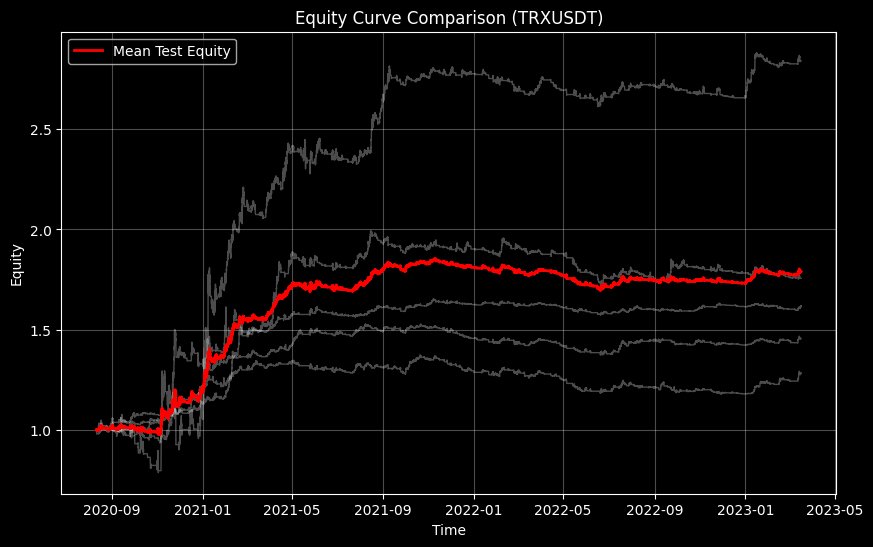

              CAR  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
BTCUSDT  0.101071    0.088020      1.095944     -0.142496      0.709286
ETHUSDT  0.155886    0.078598      1.842299     -0.101567      1.534809
XRPUSDT  0.244725    0.187333      1.174394     -0.141984      1.723614
BNBUSDT  0.203784    0.084516      2.194599     -0.049493      4.117457
SOLUSDT  0.495787    0.356852      1.128395     -0.305167      1.624643

Mean: CAR             0.240250
Volatility      0.159064
Sharpe Ratio    1.487126
Max Drawdown   -0.148141
Calmar Ratio    1.941962
dtype: float64


In [ ]:
df_train = pd.DataFrame(train_equities).dropna().pct_change().cumsum() + 1
df_test = pd.DataFrame(test_equities)

# Calculate mean test equity curve
mean_train_equity = df_train.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))

# Plot test equities (all in white)
for col in df_train.columns:
    plt.plot(df_train[col], color='white', alpha=0.3, linewidth=1, label='_nolegend_')

# Plot mean of test equities in red
plt.plot(mean_train_equity, color='red', linewidth=2, label='Mean Test Equity')

# Titles and style
plt.title(f"Equity Curve Comparison ({ticker})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.legend()

# Black background for contrast
plt.gca().set_facecolor('black')
plt.show()


from utils import performance_metrics
results = {}
for ticker in df_train.columns:
   results[ticker] = performance_metrics(df_train[ticker], periods_per_year=24* 365)

result_df = pd.DataFrame(results).T
print(result_df)
print(f"\nMean: {result_df.mean()}")

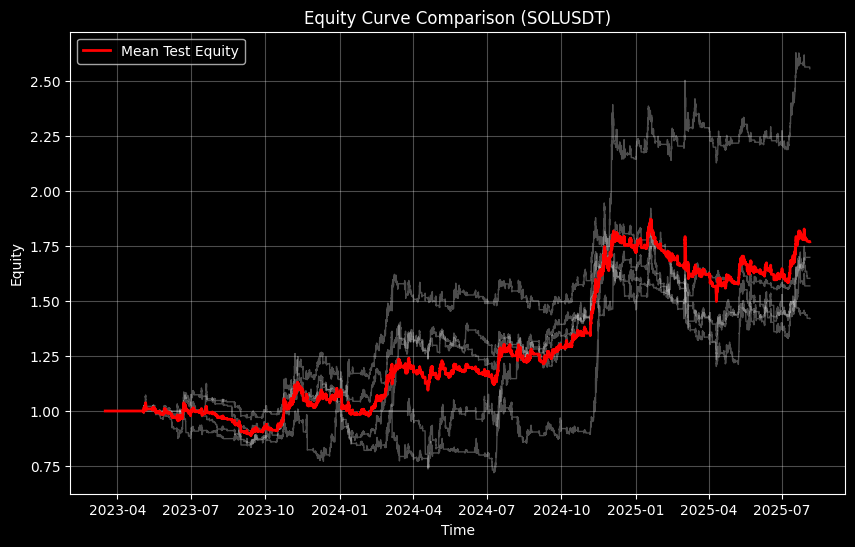

              CAR  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
BTCUSDT  0.158318    0.231946      0.633664     -0.233329      0.678517
ETHUSDT  0.218870    0.258574      0.765482     -0.360288      0.607488
XRPUSDT  0.540318    0.394187      1.095956     -0.429919      1.256789
BNBUSDT  0.256691    0.294054      0.777046     -0.253194      1.013810
SOLUSDT  0.351994    0.400385      0.753284     -0.358483      0.981900

Mean: CAR             0.305238
Volatility      0.315829
Sharpe Ratio    0.805087
Max Drawdown   -0.327043
Calmar Ratio    0.907701
dtype: float64


In [ ]:
# Calculate mean test equity curve
mean_test_equity = df_test.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))

# Plot test equities (all in white)
for col in df_test.columns:
    plt.plot(df_test[col], color='white', alpha=0.3, linewidth=1, label='_nolegend_')

# Plot mean of test equities in red
plt.plot(mean_test_equity, color='red', linewidth=2, label='Mean Test Equity')

# Titles and style
plt.title(f"Equity Curve Comparison ({ticker})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.legend()

# Black background for contrast
plt.gca().set_facecolor('black')
plt.show()

from utils import performance_metrics
results = {}
for ticker in df_test.columns:
   results[ticker] = performance_metrics(df_test[ticker], periods_per_year=24* 365)


result_df = pd.DataFrame(results).T
print(result_df)
print(f"\nMean: {result_df.mean()}")